In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [3]:
# create folder for this set of experiments
experiment_folder = "size_benchmarking"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
import skimage.io as io
input_data = io.imread('/data/combined_image.tif')
input_data = np.expand_dims(input_data, axis=0)

In [12]:
input_data = np.rollaxis(input_data, 1, 4)

In [14]:
processed = multiplex_preprocess(input_data)

In [7]:
from deepcell.model_zoo.panopticnet import PanopticNet

model_6 = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)
model_6.load_weights(MODEL_DIR + '/20201018_multiplex_seed_3__subset_2665.h5')

W1216 21:51:59.373354 140069818058560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed_mibi

app = MultiplexSegmentation(use_pretrained_weights=False)
    
tiled_data, tile_info = tile_image(processed, model_input_shape=(256, 256), stride_ratio=1)
model_output = model_6.predict(tiled_data)
inner_distance, pixelwise = app._untile_output(model_output, tile_info)
labels = deep_watershed_mibi({'inner-distance':inner_distance,
                              'pixelwise-interior': pixelwise[..., 1:2]},
                              maxima_threshold=0.1, maxima_model_smooth=0,
                              interior_threshold=0.23,
                              interior_model_smooth=2,
                              radius=3,
                              small_objects_threshold=10,
                              fill_holes_threshold=10,)


In [23]:
import xarray as xr
segmentation_labels = xr.DataArray(labeled_images,
                         coords=[input_data.coords['fovs'], range(input_data.shape[1]), 
                                 range(input_data.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(MODEL_DIR, "segmentation_labels.xr"), format="NETCDF3_64BIT")

In [26]:
input_data.to_netcdf(os.path.join(MODEL_DIR, 'deepcell_input_truncated.xr'), format="NETCDF3_64BIT")

In [25]:
MODEL_DIR

'/data/analyses/20201206_transfer_decidua'

In [17]:
import skimage.io as io
for i in range(10):
    current_fov = input_data.fovs.values[i]
    fov_folder = os.path.join(data_dir, current_fov)
    if not os.path.exists(fov_folder):
        os.makedirs(fov_folder)
    for j in [5]:
        current_img = input_data.channels.values[j]
        io.imsave(os.path.join(fov_folder, current_img + '.tiff'), input_data[i, :, :, j].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20200611_cohort/12_31750_16_12/CD56.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20200611_cohort/16_31772_4_4/CD56.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20200611_cohort/6_31731_11_6/CD56.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20200611_cohort/6_31726_8_8/CD56.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20200611_cohort/6_31727_8_10/CD56.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_

In [17]:
# save segmentations
import skimage.io as io
for i in range(10):
    current_fov = input_data.fovs.values[i]
    fov_folder = os.path.join(data_dir, current_fov)
    io.imsave(os.path.join(fov_folder, 'segmentation_6_channel.tiff'), labeled_images[i, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/12_31750_16_12/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/16_31772_4_4/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31731_11_6/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31726_8_8/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31727_8_10/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirle

In [17]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries[..., 0] > 0, :] = 1
    
    return overlay_data

In [18]:
rgb_data = make_color_overlay(processed)

In [22]:
overlays = make_outline_overlay(rgb_data[:25], labels[:25])

In [24]:
io.imsave('/data/labeled_image.tiff', labels[0, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: /data/labeled_image.tiff is a low contrast image
  """Entry point for launching an IPython kernel.


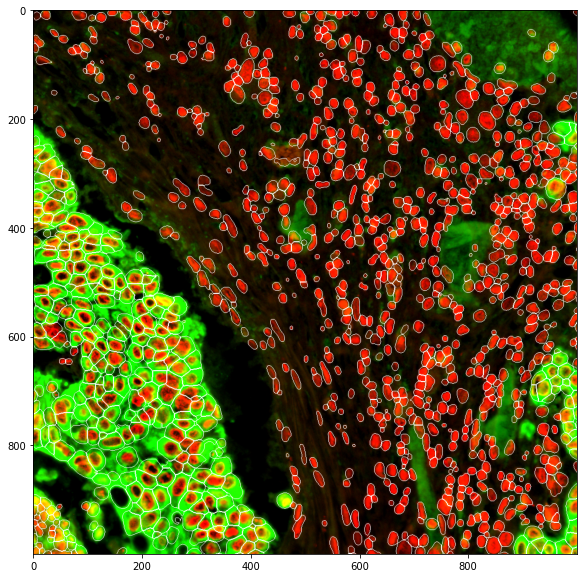

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(overlays[0, :1000, :1000, :])